# Advances in Data Mining Assignment 1
### Group 70: Prakash Srinivasan (s4065905), Jim van Veenhuyzen (s2272881), Ryan van der Werf (s2331233)
# 1 Introduction
Big data is everywhere in our day to day life and becomes increasingly important for organizations to increase their efficiency and provide better services and products to their customers. To process the ever-growing supply of data, the development of better and faster algorithms is essential. <br>
The aim of this assignment is to develop multiple recommendation algorithms in Python for the MovieLens 1M dataset. This set contains historical data of ratings (on a 1 to 5 scale) given to movies by many different users. In total, 6 different algorithms will be constructed: 4 naive approaches including linear regression, UV matrix decomposition and matrix factorization. The root mean squared error (RMSE) is used to check the accuracy of each algorithm. <br>
In this notebook we will first give a short explain the data in the used data set. Next, a bit of theory for each of the algorithms is discussed, including useful formulas. This knowledge is then implemented into the different algorithms to obtain our results. These results will then be discussed, supplemented with relevant plots and tables. The notebook end with a conclusion bas on the results and discussion.

# 2 Data
The *Movielens 1M* data set contains about 1.000.000 ratings given to about 4.000 movies by about 6.000 users. Thinking of the data as a matrix with users across the top and movies down the side, only about 1.000.000 of the total 24.000.000 are filled with a (1 to 5) rating, so most elements of the matrix are empty (most users have not rated the vast majority of the 4.000 movies). Some additional information about the users (e.g. gender) and movies (e.g. genre) is also provided in two different sets. The characteristics of the data sets are shown here:

In [94]:
print("Data set 'ratings.dat':")
print("             Type:")
print("UserID:      Integer (1 to 6040)")
print("MovieID:     Integer (1 to 3952)")
print("Rating:      Integer (1 to 5)")
print("Timestamp:   Integer ")

print("\nData set 'users.dat'")
print("             Type")
print("UserID:      Integer (1 to 6040)")
print("Gender:      String (M/F)")
print("Age:         Integer")
print("Occupation:  Integer")
print("Zip-code:    Integer")

print("\nData set 'movies.dat'")
print("             Type")
print("MovieID:     Integer (1 to 3952)")
print("Title:       String")
print("Genres:      String")

Data set 'ratings.dat':
             Type:
UserID:      Integer (1 to 6040)
MovieID:     Integer (1 to 3952)
Rating:      Integer (1 to 5)
Timestamp:   Integer 

Data set 'users.dat'
             Type
UserID:      Integer (1 to 6040)
Gender:      String (M/F)
Age:         Integer
Occupation:  Integer
Zip-code:    Integer

Data set 'movies.dat'
             Type
MovieID:     Integer (1 to 3952)
Title:       String
Genres:      String


# 3 Theory
In this section, the theory behind each of the used concepts and algorithms will be explained with their relevant equations. We will first explain the concept behind cross-validation and how it applies to our data. Then we will describe the 5 algorithms, starting with the four approaches classified as 'naive' because they are relatively easy and quick to calculate and implement. These naive approaches however cannot be used for the normalization of ratings and the cumulative improvement of the RMSE, so we will also evaluate two other approaches. 

## 3.1 Cross-validation
To make sure that our results are reliable, we are interested in the accuracy of our model on data that was not used in the training process, and we will apply the 5-fold cross-validation scheme to achieve this. The whole data set is randomly split into 5 parts of more or less equal sizes, and we will then develop 5 models for each combination of 4 our of 5 parts. Each of the 5 parts is therefore used once as a test set, while the model is trained on the remaining 4 sets. Each of the obtained models is then tested to the test set that was not used to train the model. This way we generated 5 different estimates of the model accuracy, and their average is considered to be a good estimate of the error on the future data. <br>
In this assignment, our training sets consist of ~800.000 ratings, and we will test the created model on the remaining ~200.000 ratings (test set). This was done 5 times to the completely unique test sets (this means that if all 5 test sets are combined, we obtain the total data set consisting of ~1.000.000 ratings again).

## 3.2 Naive Approaches
The following formulas that represent the 4 naive approaches were taken from slide 17.
### 3.2.1 Naive Approach 1: Global average rating
### $\;\;\;\;\;\;$ $R_{global}(User, Item) = \text{mean(all ratings})$ (Eq.1)<br>
For the first naive approach we calculated the global average rating by averaging all ratings. The empty movie-user pairs (i.e. every user-movie element in the ratings data that is not rated yet) in the training set were then simply filled with this global average rating. 
### 3.2.2 Naive Approach 2: Average rating per movie
### $\;\;\;\;\;\;$ $R_{item}(User, Item) = \text{mean(all ratings for Item})$ (Eq.2)<br>
The second naive approach uses the average rating for every movie. As mentioned in the assignment, some movies might dissapear from the training sets as all their ratings will enter the test set. To handle such cases, we used the "global average rating" as a fall-back value. 
### 3.2.3 Naive Approach 3: Average rating per user
### $\;\;\;\;\;\;$ $R_{user}(User, Item) = \text{mean(all ratings for User})$ (Eq.3)<br>
The third naive approach is very similar to the second one; we now calculate the average rating for every user. As mentioned in the assignment, some users might dissapear from the training sets as all their ratings will enter the test set. To handle such cases, we again used the "global average rating" as a fall-back value. 
### 3.2.4 Naive Approach 4: Linear regression with intercept $\gamma$
Concerning the linear regression models, we used the "full" variant of linear regression (i.e. included the $\gamma$ parameter): <br>
### $\;\;\;\;\;\;$ $R_{user-item}(User, Item) = \alpha*R_{user}(User, Item) + \beta*R_{item}(User, Item) + \gamma $ (Eq.4)<br>
$\alpha$, $\beta$ and the intercept parameter $\gamma$ are all estimated with linear regression using the training set. Using this method, every user-movie pair gets a unique rating, although the ratings can be very similar (to 7 or 8 decimals).

# 3.3 UV Matrix Decomposition
Our implementation of the UV-Decomposition Algorithm is very faithful to Section 9.4 of the MMDS textbook, more specifically following the 4-step schematic suggested at the start of Section 9.4.5. We divided the code into four functions that each represent these four steps: $\textbf{Proprocessing}$, $\textbf{initialization}$ of $\textit{U}$ and $\textit{V}$, $\textbf{optimization}$ of the elements, and the final $\textbf{convergence}$ of the algorithm. Note that despite implementing the $\textbf{Proprocessing}$ algorithm, we do not end up using it. The reason for this will be given in the following paragraph. 

### Preprocessing
The purpose of preprocessing the utility matrix $\textit{M}$ beforehand, is to appropiate scale the non-blank elements to account for the variance in how different users rate movies. More specifically, it may occur that some users are very critical, resulting in a relatively high amount of low ratings (so 1 or 2) and in turn a relatively low amount of high ratings (4 or 5). Likewise, some users are overly optimistic in their ratings, perhaps never rating a movie below a 3. The preprocessing approach is meant to combat this effect by scaling the ratings in such a manner that minimizes the bias created by these types of users.

In the Preprocessing Section of Section 9.4.5, multiple approaches are suggested to scale the ratings. In our algorithm we have applied the first of these: taking the utility matrix $\textit{M}$ with the users on rows $i$ and movies on columns $j$, we subtract from each non-blank element of $M$ the mean of row $i$, and for the resulting matrix we subtract the mean of column $j$. Note that we decided not to apply the preprocessing algorithm over our utility matrices (the train matrices). The main reason for this is that the final RMSE did not seem to improve. The UV-decomposition algorithm is already very time expensive, so cutting this out improves the efficiency of the algorithm, as the result does not necessarily improve by using it.

### Initialization
For the initialization, we have implemented a function that allows for two different methods of initilization for $U$ and $V$. The first, and the method we end up applying, is to generate the matrices with randomly generated elements being 0 and 1. We also implemented a method $\textbf{useMean}$ which if set to True, scales the matrices by a factor $\sqrt{\frac{a}{d}}$ as suggested in the book. Here, $a$ is the average value of all non-blank elements of the utility matrix, and $d$ is the length of the short axis of $U$ and $V$. We found that the difference in initialization of $U$ and $V$ was arbitrary for the resulting RSME, so we decided to just use the first and most straightforward method.

### Optimization
The optimization of the elements is arguably the most important part of the algorithm and as mentioned before, was implemented in a manner very faithful to the book, more specifically Section 9.4.4. Let $r$ and $s$ be the columns of the $U$ and $V$ matrices. Note that $r$ is a different size for $U$ than for $V$, because for $U$ the amount of the rows stands for the number of features and for $V$ it stands for the amount of 'movie-features', which has size $d$. Likewise for $U$, $s$ represents the $d$ 'user-features' and for $V$ its simply the number of movies. To optimise the elements $u_{rs}$ and $v_{rs}$, we apply the following equations from the book:

$$
    u_{rs} = \frac{v_{sj} \sum_j (m_{rj} - \sum_{k \neq s} u_{rk}v_{kj})}{\sum_j v_{sj}^2} (Eq.5)
$$
 
$$
    v_{rs} = \frac{u_{ir} \sum_i (m_{is} - \sum_{k \neq r} u_{ik}v_{ks})}{\sum_i v_{ir}^2} (Eq.6)
$$

Here, $\sum_j$ represents the summation over all columns and $\sum_i$ over all rows. The inner sum involving $k \neq $ $r$ or $s$ represents the summation over all elements $k$ = 0,1,..,$d$ except for where $k$ = $r$ or $s$. $m_{ij}$ represents the element of the utility matrix in row $i$ and column $j$. Code-wise, we went for a very basic approach by recognizing summations over elements can be represented by using for-loops. We also use for-loops to loop through all the elements. We are aware that using nested loops is slow, but we chose this approach to showcase our mathematical understanding of the problem and to improve the readability of the code: because the code is a direct translation from the equations, it is straightforward to follow. Note that choosing a high value for $d$ significantly slows down the algorithm, as the amount of operations from the summation involving $k$ will increase for each element, so we try to keep $d$ low. In this notebook, we used d=2 to run the UV decomposition and obtain our results, but for the second notebook (about Data Visualization), we used d=5 (the rest of the algorithm didn't change). Due to time limitations however we were unable to run the d=5 code in this notebook, so we used the d=2 results in this notebook.

### Convergence
In this final step, we iteratively apply the optimization of elements, calculate the RMSE per step and accept the resulting matrices if the improvement in the RMSE compared to the previous step decreases below a certain threshold. The RSME is calculated by multiplying the $U$ and $V$ matrices from the optimization algorithm, resulting in a matrix $P$, defined as $P$ = $UV$. Next we take the difference between all non-blank elements of $M$ and the corresponding elements of $P$, square them, take the mean and finally take the square root. Like the book states, an RSME of 0 is unrealistic, so we chose to work with the difference between the current and previous RMSE values. 


## 3.4 Matrix factorization

The idea behind matrix factorization is similar to that of UV matrix decomposition discussed earlier. We will follow the approach taken in the paper [$\textit{gravity-Tikk.pdf}$](https://www.cs.uic.edu/~liub/KDD-cup-2007/proceedings/gravity-Tikk.pdf) (2007). Here our goal is also to approximate the matrix with ratings, now called X, as the product of two matrices U and M:<br>
### $\;\;\;\;\;\;$ $X\approx U\cdot M$, (Eq.5)<br>
where U is an I x K and M is a K x J matrix, so that u$_{ik}$ and m$_{kj}$ can be treated as the kth feature of the ith user and the jth movie respectively. The major differences with the UV decomposition is that we update the matrices U and M differently, and that they are also initialized differently. <br>
<br>
We first initialize the two matrices U and M by filling them with values between 0 and 1. We then iterate over each known rating element of X and compute the training error on the (i, j)th example:<br>
### $\;\;\;\;\;\;$ e$_{ij}$ = x$_{ij}$ - $ \sum_{k=1}^{K} u_{ik}m_{kj}  $, (Eq.6)<br>
where e$_{ij}$ is the training error on the (i, j)th example and x$_{ij}$ is an element in the matrix X. u$_{ij}$ and m$_{ij}$ denote the elements of U and M, so the sum in eq.2 denotes how the ith user would rate the jth movie according to the model. <br>
To minimize the RMSE, we have applied a simple gradient descent method to find a local minimum. The gradient of $e^2_{ij}$ is given by:<br>
### $\;\;\;\;\;\;$ $\frac{\partial}{\partial u_{ik}}e^2_{ij} = -2 e_{ij} \cdot m_{kj} $, $\frac{\partial}{\partial m_{kj}}e^2_{ij} = -2 e_{ij} \cdot u_{ik} $(Eq.7)<br>
We then updated the weights in U and M in the opposite direction of the gradient to decrease the error, thereby better approximating x$_{ij}$. Furthermore, a regularization which prevents large weights is implemented to obtain a better prediction for unseen examples. The updated elements can now be calculated according to eq.3:<br>
### $\;\;\;\;\;\;$ u'$_{ik}$ = u$_{ik}$ + $\eta$(2e$_{ij}$m$_{kj}$ - $\lambda$u$_{ik}$$)$, (Eq.8)<br>
### $\;\;\;\;\;\;$ m'$_{kj}$ = m$_{kj}$ + $\eta$(2e$_{ij}$u$_{ik}$ - $\lambda$m$_{kj}$$)$, (Eq.9) <br>
where $\eta$ is the learning rate and $\lambda$ is the regularization.

We go through each known element of X which is not in the probe subset using for-loops and apply eq.6 & 7 to update U and M. After each loop the RMSE w.r.t. the probe subset is computed to see if it has improved (i.e. decreased) from the previous iteration. If the RMSE has improved less than 1e-5 compared to the previous step, the process is stopped and we accept the last RMSE value for that fold. For this assignment, we used a dimension of K=10 for the matrices U and M, a regularization of r=0.05, a learling rate of l=0.005 and a stop at 75 iterations through the loop. If the RMSE did not improve during two iterations, the loop is also terminated. 

# 4 Results

# 4.1 Naive Approaches

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import sys
import os

import datetime
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [51]:
#Users data
usersData = pd.read_csv('users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

#Ratings data
ratingsData = pd.read_csv('ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')

#Movies data
moviesData = pd.read_csv('movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin1')

#Users data
print("usersData:")
print(usersData.head())

#Ratings data
print("\nratingsdata:")
print(ratingsData.head())

#Movies data
print("\nmoviesData:")
print(moviesData.head())

usersData:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

ratingsdata:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

moviesData:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy


# 4.1.1 Naive Approach 1: Global average rating

In [52]:
#Calculating the Global Average Rating
globalAvgRating = ratingsData["Rating"].mean()
print("The Global Average Rating is", globalAvgRating)

The Global Average Rating is 3.581564453029317


In [53]:
#Initialising the variables for error metrics
totalMAE = 0
totalRMSE = 0

#Performing 5 fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train_index, test_index in kf.split(ratingsData):
    trainSet = ratingsData.iloc[train_index]
    testSet = ratingsData.iloc[test_index]

    #Global average Rating
    globalAverageRating = trainSet["Rating"].mean()

    #Dictionaries to store user and movie average ratings
    userAverageRating = trainSet.groupby("UserID")["Rating"].mean().to_dict()
    movieAverageRating = trainSet.groupby("MovieID")["Rating"].mean().to_dict()

    #List to store predictions
    predictions = []

    #Iterating through the test set and make predictions
    for _, row in testSet.iterrows():
        user_id = row["UserID"]
        movie_id = row["MovieID"]

        #Condition to check if user or movie is not in the training data
        if user_id not in userAverageRating or movie_id not in movieAverageRating:
            predictedRating = globalAverageRating
        else:
            #Calculating the predicted rating using the user and movie average
            predictedRating = (
                userAverageRating.get(user_id, globalAverageRating)
                + movieAverageRating.get(movie_id, globalAverageRating)
                - globalAverageRating
            )

        # Ensure the predicted rating is within the valid range [1, 5]
        predictedRating = min(5, max(1, predictedRating))

        predictions.append(predictedRating)

    #Replacing the NAN values with global average rating
    predictions = [globalAvgRating if np.isnan(x) else x for x in predictions]

    #Calculating MAE and RMSE
    mae = mean_absolute_error(testSet["Rating"], predictions)
    rmse = np.sqrt(mean_squared_error(testSet["Rating"], predictions))

    totalMAE += mae
    totalRMSE += rmse

# Calculate the average MAE and RMSE over all folds
averageMAE = totalMAE / 5
averageRMSE = totalRMSE / 5

print("The Average MAE is", averageMAE)
print("The Average RMSE is", averageRMSE)

The Average MAE is 0.7327214582778845
The Average RMSE is 0.933967790381811


# 4.1.2 Naive Approach 2: Average rating per movie

In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

MAE_Scores = []
RMSE_Scores = []

for train_index, test_index in kf.split(ratingsData):
    trainSet, testSet = ratingsData.iloc[train_index], ratingsData.iloc[test_index]

    #Avereage rating for each of the movies
    AvgMovieRating = ratingsData.groupby('MovieID')['Rating'].mean().to_dict()

    #Predicting the movie ratings in the test set and getting a copy of the slice
    testSet = testSet.copy()
    testSet['PredictedRating'] = testSet['MovieID'].map(AvgMovieRating)

    #MAE & RMSE
    MAE = mean_absolute_error(testSet['Rating'], testSet['PredictedRating'])
    RMSE = mean_squared_error(testSet['Rating'], testSet['PredictedRating'], squared=False)

    MAE_Scores.append(MAE)
    RMSE_Scores.append(RMSE)

# Calculate average MAE and RMSE over all folds
Avg_MAE = np.mean(MAE_Scores)
Avg_RMSE = np.mean(RMSE_Scores)

print("The Average MAE is", Avg_MAE)
print("The Average RMSE is", Avg_RMSE)

The Average MAE is 0.77879021845446
The Average RMSE is 0.9747113013367519


# 4.1.3 Naive Approach 3: Average rating per user

In [55]:
#User Average rating
kf = KFold(n_splits=5, shuffle=True, random_state=1)

MAE_Scores = []
RMSE_Scores = []

for train_index, test_index in kf.split(ratingsData):
    trainSet, testSet = ratingsData.iloc[train_index], ratingsData.iloc[test_index]

    # Avg user rating for the training set
    AvgUserRating = trainSet.groupby('UserID')['Rating'].mean().to_dict()

    #Predicting the user ratings in the test set and getting a copy of the slice
    testSet = testSet.copy()
    testSet['PredictedRating'] = testSet['UserID'].map(AvgUserRating)

    #MAE and RMSE
    MAE = mean_absolute_error(testSet['Rating'], testSet['PredictedRating'])
    RMSE = np.sqrt(mean_squared_error(testSet['Rating'], testSet['PredictedRating']))

    MAE_Scores.append(MAE)
    RMSE_Scores.append(RMSE)

# Calculate average MAE and RMSE over all folds
Avg_MAE = np.mean(MAE_Scores)
Avg_RMSE = np.mean(RMSE_Scores)

print("The Average MAE is", Avg_MAE)
print("The Average RMSE is", Avg_RMSE)

The Average MAE is 0.8290076950378935
The Average RMSE is 1.0354887413559268


# 4.1.4 Naive Approach 4: Linear regression with intercept $\gamma$

In [101]:
# Initialising the variables for error metrics
totalMAE_userItem = 0
totalRMSE_userItem = 0

count_kfold = 1
# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

alpha, beta, gamma, RMSE = [], [], [], []

for train_index, test_index in kf.split(ratingsData):
    train_set = ratingsData.iloc[train_index]
    test_set = ratingsData.iloc[test_index]

    # Linear regression to estimate alpha, beta_user, and gamma_userItem
    X = train_set[['UserID', 'MovieID']]
    y = train_set['Rating']

    model = LinearRegression()
    model.fit(X, y)

    alpha_userItem = model.coef_[0]
    alpha.append(alpha_userItem)
    beta_userItem = model.coef_[1]
    beta.append(beta_userItem)
    gamma_userItem = model.intercept_
    gamma.append(gamma_userItem)

    # To store predictions for Ruser-item(user, item)
    predictions_userItem = []

    #Iterating the testset to make the predictions
    for _, row in test_set.iterrows():
        user_id = row['UserID']
        movie_id = row['MovieID']

        #Calculating the predicted rating
        if user_id in userAverageRating and movie_id in movieAverageRating:
            predictedRating_UserItem = alpha_userItem * userAverageRating[user_id] + beta_userItem * movieAverageRating[movie_id] + gamma_userItem
        else:
            predictedRating_UserItem = globalAvgRating

       #Checking that the predicted rating is within the valid range [1,5]
        predictedRating_UserItem = min(5, max(1, predictedRating_UserItem))
        predictions_userItem.append(predictedRating_UserItem)

    #Calculating MAE and RMSE for Ruser-item(user, item)
    mae_userItem = mean_absolute_error(test_set['Rating'], predictions_userItem)
    rmse_userItem = np.sqrt(mean_squared_error(test_set['Rating'], predictions_userItem))

    totalMAE_userItem += mae_userItem
    totalRMSE_userItem += rmse_userItem
    
    RMSE.append(rmse_userItem)
    
    count_kfold += 1

#Calculating the average MAE & RMSE for Ruser-item(user,item) overall folds
averageMAE_userItem = totalMAE_userItem / 5
averageRMSE_userItem = totalRMSE_userItem / 5

#print the found values of alpha, beta, gamma and the RMSE for every fold 
print("\nFor fold 1: ")
print("alpha = ", alpha[0], "beta = ", beta[0], "gamma = ", gamma[0], "RMSE = ", RMSE[0])
print("\nFor fold 2: ")
print("alpha = ", alpha[1], "beta = ", beta[1], "gamma = ", gamma[1], "RMSE = ", RMSE[1])
print("\nFor fold 3: ")
print("alpha = ", alpha[2], "beta = ", beta[2], "gamma = ", gamma[2], "RMSE = ", RMSE[2])
print("\nFor fold 4: ")
print("alpha = ", alpha[3], "beta = ", beta[3], "gamma = ", gamma[3], "RMSE = ", RMSE[3])
print("\nFor fold 5: ")
print("alpha = ", alpha[4], "beta = ", beta[4], "gamma = ", gamma[4], "RMSE = ", RMSE[4])


print("\nThe Average of alpha is", (alpha[0]+alpha[1]+alpha[2]+alpha[3]+alpha[4])/5)
print("The Average of beta is", (beta[0]+beta[1]+beta[2]+beta[3]+beta[4])/5)
print("The Average of gamma is", (gamma[0]+gamma[1]+gamma[2]+gamma[3]+gamma[4])/5)

print("\nThe Average MAE for Ruser-item(user, item) is", averageMAE_userItem)
print("The Average RMSE for Ruser-item(user, item) is", averageRMSE_userItem)


For fold 1: 
alpha =  6.783141972199692e-06 beta =  -6.45928889400591e-05 gamma =  3.6815259814475048 RMSE =  1.120688769999563

For fold 2: 
alpha =  6.49156923096687e-06 beta =  -6.555495413579753e-05 gamma =  3.6847200077716016 RMSE =  1.1232959555074935

For fold 3: 
alpha =  7.758749109455263e-06 beta =  -6.487328497086093e-05 gamma =  3.6796767384662963 RMSE =  1.123964662285164

For fold 4: 
alpha =  7.947901399707865e-06 beta =  -6.512290382819396e-05 gamma =  3.6784218057858014 RMSE =  1.1186357776547278

For fold 5: 
alpha =  7.11746387283407e-06 beta =  -6.520975642971364e-05 gamma =  3.6812560297311996 RMSE =  1.1210429591912459

The Average of alpha is 7.2197651170327525e-06
The Average of beta is -6.507075766092503e-05
The Average of gamma is 3.6811201126404804

The Average MAE for Ruser-item(user, item) is 0.9189404451158604
The Average RMSE for Ruser-item(user, item) is 1.1215256249276389


### Comments on results:

The output above shows the values of $\alpha$, $\beta$ and $\gamma$ that were found using linear regression. This part of the code took less than a minute to run. <br>
The average of alpha (α): Coefficient for user average ratings and the values are quite small, indicating that user average ratings having a minimal impact on the predicted movie ratings.<br>

The average of beta (β): Coefficient for movie average ratings. Similar to alpha, the values of Beta are also small, suggesting that movie average ratings have a limited influence on the predicted movie ratings.<br>

The average gamma (γ): Intercept term, representing the global bias or the average movie rating. This value is around 3.75 for each fold, which implies that, on average, the predicted ratings are biased upwards by approximately 3.75.<br>

Summary of Linear Regression Model:
User average ratings & movie average ratings have very small coefficients, suggesting that their influence on the predicted movie ratings is minimal. The global bias (Gamma) of around 3.75 indicates that the predicted ratings tend to be higher on average than the true ratings. The results suggest that, in this specific model data, the linear regression model places more emphasis on the global bias (Gamma) and less on user and movie average ratings when making predictions. The low values of Alpha and Beta indicate that user and movie-specific effects have limited predictive power.

# 4.2 UV Matrix Decomposition

In [63]:
def preprocessing(utility_matrix):
    """
    Preprocessing a utility matrix using the method described in paragraph 9.4.5 of the book.

    Arguments:
        utility_matrix (numpy.ndarray): utility matrix to be preprocesed

    Return:
        numpy.ndarray: preprocessed utility matrix

    Below function performs the mean-centering on the utility matrix, it calculates the mean of the each row and 
    subtracts it from all the non NAN elements in the same row and then it calculates the mean of the each column 
    and subtracts it from all non NAN elements in the same column. As a result the utility matrix with row and 
    column means centered around zero.
    """
    M = np.copy(utility_matrix)

    numRows = np.shape(M)[0]
    numCol = np.shape(M)[1]

    for i in range(numRows):
        rowMean = np.nanmean(M[i, :])
        for j in range(numCol):
            if not math.isnan(M[i, j]):
                M[i, j] -= rowMean

    for j in range(numCol):
        columnMean = np.nanmean(M[:, j])
        for i in range(numRows):
            if not math.isnan(M[i, j]):
                M[i, j] -= columnMean
    return M

In [64]:
def initUV(M, d, useMean):
    """
    Initializing the matrices U and V

    Arguments:
        M (numpy.ndarray): utility matrix.
        d (int): number of latent factors.
        useMean (bool): If true, initialize U and V with mean-based scaling.

    Returns:
        tuple: tuple contains the initialized U and V matrices.

    Below function initilise the U & V matrices. At first it generates random values between 0 & 1 for u and v. If use_mean is true, it further scales the matrices
    by a scalar calculated from teh mean of the utilitiy matrix and the number of latent factors. The initialized u and v matrices are returned as a tuple.
    """
    numRows = np.shape(M)[0]
    numCol = np.shape(M)[1]

    # Initialize U and V with random values between 0 and 1
    U = np.random.rand(numRows, d)
    V = np.random.rand(d, numCol)

    if useMean:
        scalar = np.sqrt(np.nanmean(M) / (d * numRows))
        return scalar * U, scalar * V
    return U, V

In [65]:
def optimizeElements(M, U, V):
    """
    It Optimises the elements of matrices U and V

    Arguments:
        M (numpy.ndarray): utility matrix.
        U (numpy.ndarray): U matrix.
        V (numpy.ndarray): V matrix.

    Returns:
        tuple: tuple contais the optimized U and V matrices.

    Below function optimises the elements of matrices u and v. It iterates through the rows and columns fo the utility matrix M, and updating the elements
    of u and v. Then the updated u and v matrices are returned as tuple.
    """
    numRows = np.shape(M)[0]
    numCol = np.shape(M)[1]
    d = np.shape(U)[1]

    for r in range(numRows):
        for s in range(d):
            totalNom = 0
            totalDenom = 0
            for j in range(numCol):
                if not math.isnan(M[r, j]):
                    eps = 0
                    for k in range(d):
                        if k != s:
                            eps += U[r, k] * V[k, j]
                    totalNom += V[s, j] * (M[r, j] - eps)
                    denom = (V[s, j]) ** 2
                    totalDenom += denom
            U[r, s] = totalNom / totalDenom

    for r in range(d):
        for s in range(numCol):
            totalNom = 0
            totalDenom = 0
            for i in range(numRows):
                if not math.isnan(M[i, s]):
                    eps = 0
                    for k in range(d):
                        if k != r:
                            eps += U[i, k] * V[k, s]
                    totalNom += U[i, r] * (M[i, s] - eps)
                    denom = (U[i, r]) ** 2
                    totalDenom += denom
            V[r, s] = totalNom / totalDenom
    return U, V

In [66]:
def convergeUV(M_train, M_test, U, V):
    """
    It iterates to converge U and V

    Arguments:
        M_train (numpy.ndarray): training utility matrix.
        M_test (numpy.ndarray): test utility matrix.
        U (numpy.ndarray): initial U matrix.
        V (numpy.ndarray): initial V matrix.

    Returns:
        tuple: tuple contains the converged U and V matrices, the predicted P matrix, and the final RMSE.

    Below function iterates and updates the u and v matrices until the convergence. It compares the predicted P matrix and caluclates the RMSE to check
    for convergence. The iteration continues until the difference between the old and new RMSE is less than 1e-5, the converged u and v matrices,
    along with the predicted P matrix and final RMSE are returned as a tuple.
    """
    count = 0
    rmseOld = float('inf')
    rmseNew = 1

    while (rmseOld - rmseNew) > 1e-5:
        U, V = optimizeElements(M_train, U, V)
        P = np.dot(U, V)
        diff = M_test - P
        rmseOld = rmseNew
        rmseNew = np.sqrt(np.nanmean(diff ** 2))
        if count_kfold==1: #add the RMSE values per iterations to lists
            RMSE_valuesUV1.append(rmseNew)
        if count_kfold==2:
            RMSE_valuesUV2.append(rmseNew)
        if count_kfold==3:
            RMSE_valuesUV3.append(rmseNew)
        if count_kfold==4:
            RMSE_valuesUV4.append(rmseNew)
        if count_kfold==5:
            RMSE_valuesUV5.append(rmseNew)
        count += 1

    return U, V, P, rmseNew

In [67]:
def saveUVMatrices(U, V, foldNum, output_dir):
    uFilename = os.path.join(output_dir, f"U_matrix_fold{foldNum}.npy")
    vFilename = os.path.join(output_dir, f"V_matrix_fold{foldNum}.npy")
    np.save(uFilename, U)
    np.save(vFilename, V)
    
RMSE_valuesUV1, RMSE_valuesUV2, RMSE_valuesUV3, RMSE_valuesUV4, RMSE_valuesUV5 = [], [], [], [], []
    
count_kfold = 1
kf = KFold(n_splits=5, shuffle=True, random_state=1)

totalRMSE = 0
output_dir = "/content"
os.makedirs("/content/aidm", exist_ok=True)

# Initializing an empty list to store the RMSE values for each fold
rmseValues = []

for train_index, test_index in kf.split(ratingsData):
    print("\nFold number:", count_kfold)
    now = datetime.datetime.now()
    print("Time at the start of fold number", count_kfold, ":", now.strftime("%Y-%m-%d %H:%M:%S"))

    train_set = ratingsData.iloc[train_index]
    test_set = ratingsData.iloc[test_index]

    #Determining the common set of movies and users in both set
    common_users = np.intersect1d(train_set['UserID'], test_set['UserID'])
    common_movies = np.intersect1d(train_set['MovieID'], test_set['MovieID'])

    #Filtering the data to include only common movie and users
    train_set = train_set[(train_set['UserID'].isin(common_users)) & (train_set['MovieID'].isin(common_movies))]
    test_set = test_set[(test_set['UserID'].isin(common_users)) & (test_set['MovieID'].isin(common_movies))]

    #Converting the data into numpy arrays
    df_train = train_set.pivot(index="UserID", columns="MovieID", values="Rating")
    df_test = test_set.pivot(index="UserID", columns="MovieID", values="Rating")
    M_train = np.array(df_train.to_numpy())
    M_test = np.array(df_test.to_numpy())

    print("Training set:")
    print(M_train)
    print("Test set:")
    print(M_test)

    Ui, Vi = initUV(M_train, 2, False)
    U, V, P, rmse = convergeUV(M_train, M_test, Ui, Vi)
    rmseValuesFold = []

    #Initialising rmseOld to a large value
    rmseOld = float('inf')
    #Initilising the convergence threshold
    convergenceThreshold = 0.001

    print("Training matrix M:\n", M_train)
    print("Predicted matrix P:\n", P)

    while True:
        U, V, P, rmse = convergeUV(M_train, M_test, Ui, Vi)
        #appending the RMSE at each itteration
        rmseValuesFold.append(rmse)
        #updating ui & vi for the next iteration
        Ui, Vi = U, V

        #checking the convergence based on the change in RMSE
        if abs(rmse - rmseOld) < convergenceThreshold:
            break

        rmseOld = rmse

    saveUVMatrices(U, V, count_kfold, output_dir)
    #Appending the RMSE values for the fold
    rmseValues.append(rmseValuesFold)
    print("RMSE estimate of fold number", count_kfold, ":", rmse)

    totalRMSE += rmse
    count_kfold += 1

#Saving the RMSE values for each fold
for i, rmseValuesFold in enumerate(rmseValues):
    print(f'fold_{i + 1}', rmseValuesFold)
    np.save(f'fold_{i + 1}_rmse.npy', rmseValuesFold)

# Calculate the average RMSE over all folds
averageRMSE = totalRMSE / 5

print("The Average RMSE is", averageRMSE)


Fold number: 1
Time at the start of fold number 1 : 2023-10-22 23:31:32
Training set:
[[ 5. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [ 3. nan nan ... nan nan nan]]
Test set:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Training matrix M:
 [[ 5. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [ 3. nan nan ... nan nan nan]]
Predicted matrix P:
 [[4.35090176 4.09479066 4.23102657 ... 3.87897414 3.07974534 3.91235348]
 [4.10898715 3.39081867 3.3087058  ... 3.67348403 3.48808703 3.72884566]
 [4.32249524 3.62690474 3.56703023 ... 3.86308207 3.59644972 3.91832268]
 ...
 [3.56312727 2.16886475 1.75625176 ... 3.20197595 3.96350366 3

Training set 1: RMSE =  0.8888324420765696
Training set 2: RMSE =  0.8876422118523113
Training set 3: RMSE =  0.8840672403118945
Training set 4: RMSE =  0.8863436577854473
Training set 5: RMSE =  0.8868710216852542
Average over 5 sets: RMSE =  0.8867513147422954

Average number of iterations: 41.2


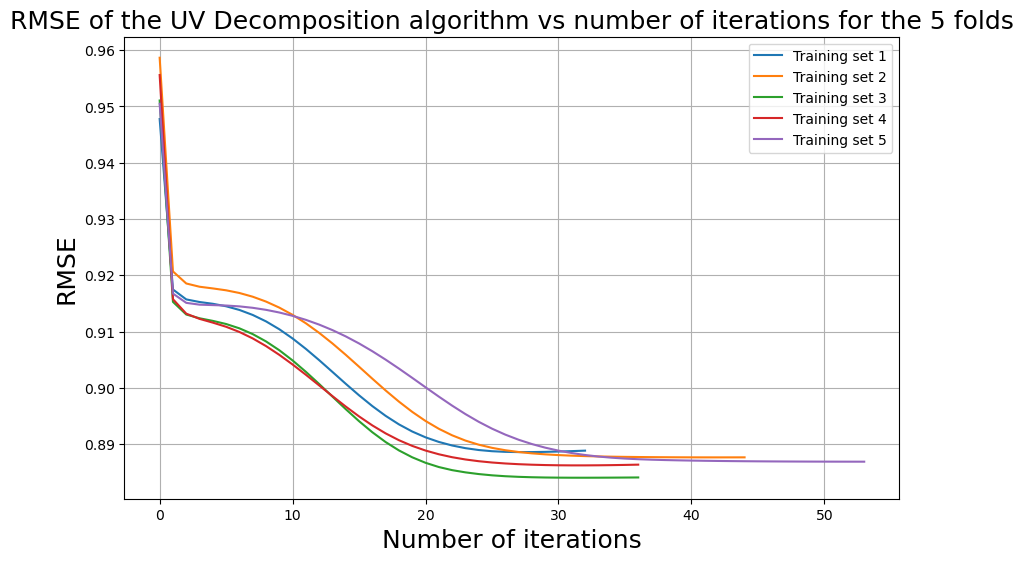

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(RMSE_valuesUV1, label="Training set 1")
plt.plot(RMSE_valuesUV2, label="Training set 2")
plt.plot(RMSE_valuesUV3, label="Training set 3")
plt.plot(RMSE_valuesUV4, label="Training set 4")
plt.plot(RMSE_valuesUV5, label="Training set 5")
plt.xlabel("Number of iterations", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.legend()
plt.grid()
plt.title("RMSE of the UV Decomposition algorithm vs number of iterations for the 5 folds", fontsize=18)

print("Training set 1: RMSE = ", RMSE_valuesUV1[-1])
print("Training set 2: RMSE = ", RMSE_valuesUV2[-1])
print("Training set 3: RMSE = ", RMSE_valuesUV3[-1])
print("Training set 4: RMSE = ", RMSE_valuesUV4[-1])
print("Training set 5: RMSE = ", RMSE_valuesUV5[-1])
print("Average over 5 sets: RMSE = ", averageRMSE)

print("\nAverage number of iterations:", (len(RMSE_valuesUV1) + len(RMSE_valuesUV2) + len(RMSE_valuesUV3) 
                                        + len(RMSE_valuesUV4) + len(RMSE_valuesUV5))/5)

### Comments on results:
The code we wrote for the UV decomposition takes a lot longer to run than the naive approaches. As can be seen in the output above, it took nearly 1.5 hours to complete the 5-fold cross-validation. The algorithm stopped when the convergence threshold of 0.001 was reached, and the runtime to reach this value was different for every fold, with an average of 41.2 iterations. In the graph we can also see that the number of iterations to reach this threshold was quite different, and this will be discussed in the discussion (section 5).<br>
The RMSE on the train sets seems to converge to a value between 0.885 and 0.89 if we look at the above figure. Interestingly, the RMSE decreases considerably in the first step but quickly starts decreasing less and less for the next few iterations. After around 7 iterations however, the RMSE starts to decrease more quickly again, only to also slow down again after around 20 iterations. The shape of the plots will also be discussed in section 5. After 30 iterations, the RMSE change very little. Looking at the flatness of the plots after this point, we can assume that we are close to the RMSE minimum. Training set 3 has the best RMSE while the first training set has the worst RMSE. The goal of the 5-fold cross-validation was to improve the accuracy by taking the average of the 5 RMSE values, and this average is determined to be $\approx$0.88675. 



# 4.3 Matrix Factorization

In [69]:
def init_UM(X_train, K):
    """
    This function initializes two matrices U and V for the UV-decomposition
    
    Arguments:
        X_train: Training matrix of this fold
        K: Number of factors
        
    Returns:
        The matrices U and M with random weights
    """
    
    I, J = X_train.shape
    U_i = np.random.rand(I, K) #U is an I x K matrix with randomly distributed weights 
    M_i = np.random.rand(J, K) #M is an K x J matrix with randomly distributed weights 

    return U_i, M_i



In [70]:
def optimize_elements(X_train, K, num_iter, r, l, U, M):
    """
    Perform a single round of optimization for the U and M matrices using the equations from page 3.4 
    
    Arguments:
        X_train: Training matrix of this fold
        K: Number of factors
        num_iter: number of iterations
        r: regularization factor
        l: learning rate
        U & M: input matrices U and M that should be updated
        
    Returns:
        The updated matrices U and M
    """

    I, J = X_train.shape

    for i in range(I):
        for j in range(J):
            if X_train[i, j] >0: #i.e. non-NaN
                eij = X_train[i, j] - np.dot(U[i, :], M[j, :])
                #eij denotes the training error on the (i, j)th example

                for k in range(K):
                    #For all latent features, apply eq.6&7 in gravity-Tikk.pdf
                    U[i, k] = U[i, k] + l * (2 * eij * M[j, k] - r * U[i, k])
                    M[j, k] = M[j, k] + l * (2 * eij * U[i, k] - r * M[j, k])

    return U, M




In [71]:
totalRMSE = 0

K, num_iter, r, l = 10, 75, 0.05, 0.005 #these are the parameters that are reported on the MyMedialite website

def converge_UM(X_train, X_test, U_i, M_i):
    """
    With this function we iterate upon the element optimization of U and V, stopping when the improvement 
    over the previous iteration becomes insignificant (<1e-5). 
    
    Arguments:
        X_train: Training matrix of this fold
        X_test: Test matrix of this fold
        U_i & M_i: original matrices U and M 
        
    Returns:
        The updated matrices U and M, the predicted matrix P and the rmse of P w.r.t. X_test
    """
    count = 1 #count the number of iterations
    
    
    #initialize the errors of the previous and current step such that the condition is held for the first loop 
    rmse_old = float('inf')
    rmse_new = 10

    
    while (rmse_old - rmse_new > 1e-5) and count <= num_iter:
        
        
        U,M = optimize_elements(X_train, K, num_iter, r, l, U_i, M_i)
        P = np.matmul(U, M.T)
        diff = X_test - P
        rmse_old = rmse_new
        rmse_new = np.sqrt(np.nanmean(diff**2)) #compute the Root-Mean Square Error between the two matrices M and P 

        if count_kfold==1: #add the RMSE values per iterations to lists
            RMSE_valuesMF1.append(rmse_new)
        if count_kfold==2:
            RMSE_valuesMF2.append(rmse_new)
        if count_kfold==3:
            RMSE_valuesMF3.append(rmse_new)
        if count_kfold==4:
            RMSE_valuesMF4.append(rmse_new)
        if count_kfold==5:
            RMSE_valuesMF5.append(rmse_new)
        print('loop number {}'.format(count), "RMSE:", rmse_new)
        count += 1
        
    return U,M,P, rmse_new #return the final, updated U and M


RMSE_valuesMF1, RMSE_valuesMF2, RMSE_valuesMF3, RMSE_valuesMF4, RMSE_valuesMF5 = [], [], [], [], []

count_kfold = 1
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train_index, test_index in kf.split(ratingsData):
    print("\nFold number:", count_kfold)
    now = datetime.datetime.now() #To check how long it takes to run 
    print ("Time at start of fold number", count_kfold, " :", now.strftime("%Y-%m-%d %H:%M:%S"))   
    
    train_set = ratingsData.iloc[train_index]
    test_set = ratingsData.iloc[test_index]
    
    # Save the user and movie IDs from the training/test set of this fold, for data visualisation later! 
    userIDs = df_train.index.values #test and train IDs are equivalent due to the condition above
    movieIDs = df_train.columns.to_list()
    np.save("userID_fold"+str(count_kfold), userIDs)
    np.save("movieID_fold"+str(count_kfold), movieIDs)
    
    #First, determine the common set of movies and users in both sets
    common_users = np.intersect1d(train_set['UserID'], test_set['UserID'])
    common_movies = np.intersect1d(train_set['MovieID'], test_set['MovieID'])

    # Filter the data to include only the common movies and users
    train_set = train_set[(train_set['UserID'].isin(common_users)) & (train_set['MovieID'].isin(common_movies))]
    test_set = test_set[(test_set['UserID'].isin(common_users)) & (test_set['MovieID'].isin(common_movies))]

    # Convert data into a numpy array
    df_train = train_set.pivot(index="UserID", columns="MovieID", values="Rating")
    df_test = test_set.pivot(index="UserID", columns="MovieID", values="Rating")
    X_train = np.array(df_train.to_numpy())
    X_test = np.array(df_test.to_numpy())
    
    print("Training set:")
    print(X_train)
    print("Test set:")
    print(X_test)

    U_i, M_i = init_UM(X_train, K)
    U, M, P, rmse = converge_UM(X_train, X_test, U_i, M_i)
    
    #After the optimization is done, print the training and predicted matrices again to possibly compare them
    print("Training matrix M:\n", X_train)
    print("Predicted matrix P:\n", P)

    print("RMSE estimate of fold number ", count_kfold, ": ", rmse)
    
    
    totalRMSE += rmse  

    np.save("predicted_U_"+str(count_kfold), U)
    np.save("predicted_M_"+str(count_kfold), M)
    count_kfold += 1
    

# Calculate the average RMSE over all folds
averageRMSE_MF = totalRMSE / 5
averageMAE_MF = totalMAE / 5

print("The Average RMSE is", averageRMSE_MF)




Fold number: 1
Time at start of fold number 1  : 2023-10-23 07:04:32
Training set:
[[ 5. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [ 3. nan nan ... nan nan nan]]
Test set:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
loop number 1 RMSE: 1.0272188087362293
loop number 2 RMSE: 0.9390548482435581
loop number 3 RMSE: 0.9360088832380927
loop number 4 RMSE: 0.932944917881418
loop number 5 RMSE: 0.9277447567971365
loop number 6 RMSE: 0.9209847522412883
loop number 7 RMSE: 0.9144530307171602
loop number 8 RMSE: 0.9088800488082256
loop number 9 RMSE: 0.9042874348958532
loop number 10 RMSE: 0.9005735950979716
loop number 11 RMSE: 0.8975943388214619
loop number 12 RMSE: 0.8951943500756887
loop number 13 RMSE: 0.8932358609447277
loop number 

Training set 1: RMSE =  0.8797894204719197
Training set 2: RMSE =  0.8789942548170769
Training set 3: RMSE =  0.8764744378356082
Training set 4: RMSE =  0.8774541807464314
Training set 5: RMSE =  0.879070196686763
Average over 5 sets: RMSE =  0.8783564981115598

Average number of iterations: 54.6


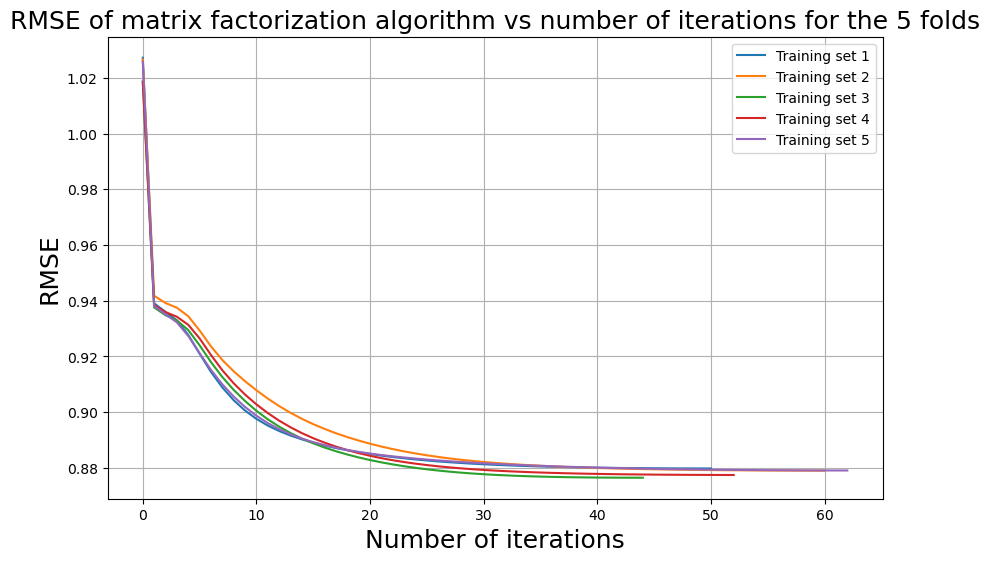

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(RMSE_valuesMF1, label="Training set 1")
plt.plot(RMSE_valuesMF2, label="Training set 2")
plt.plot(RMSE_valuesMF3, label="Training set 3")
plt.plot(RMSE_valuesMF4, label="Training set 4")
plt.plot(RMSE_valuesMF5, label="Training set 5")
plt.xlabel("Number of iterations", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.legend()
plt.grid()
plt.title("RMSE of matrix factorization algorithm vs number of iterations for the 5 folds", fontsize=18)

print("Training set 1: RMSE = ", RMSE_valuesMF1[-1])
print("Training set 2: RMSE = ", RMSE_valuesMF2[-1])
print("Training set 3: RMSE = ", RMSE_valuesMF3[-1])
print("Training set 4: RMSE = ", RMSE_valuesMF4[-1])
print("Training set 5: RMSE = ", RMSE_valuesMF5[-1])
print("Average over 5 sets: RMSE = ", averageRMSE_MF)

print("\nAverage number of iterations:", (len(RMSE_valuesMF1) + len(RMSE_valuesMF2) + len(RMSE_valuesMF3) 
                                        + len(RMSE_valuesMF4) + len(RMSE_valuesMF5))/5)

### Comments on results:
Since matrix factorization is a similar approach to the UV matrix decomposition, we expected a similar runtime for both algorithms, and indeed this turned out to be the case; the time needed to complete the 5-fold cross-factorization for the UV matrix decomposition was about 2 hours. The number of iterations is a bit larger than that of the UV decomposition (54.6 vs 41.2), and this might explain the additional runtime. For the matrix factorization algorithm, the convergence threshold was set at 1e-5 (0.00001), a factor 100 smaller than the threshold for the UV decomposition (0.001). This apparently didn't affect the runtime or number of iterations drastically. The above figure also shows the same shape as the UV matrix decomposition, with a large drop after the first iteration and gradual decrease for later iterations, and this will again be discussed in section 5. <br>
The average RMSE value over the 5 folds is $\approx$0.87836, which is almost 0.01 smaller than the average RMSE of the UV decomposition. This suggests that the matrix factorization algorithm we wrote works better than the UV matrix decomposition algorithm. 

# 5 Discussion

### 5.1 Comparing runtime
The naive approaches were easily the fastest in terms of total runtime. Comparing the runtime and number of iterations of the UV matrix decomposition (respectively about 1.5 hour and 41.2) with the matrix factorization (about 2 hours and 54.6), we conclude that the two algorithms we created are similar in terms of runtime/iteration. 

### 5.2 Comparing accuracy
Comparing the RMSE values of the different algorithms, we see that our naive approaches have the highest RMSE values, and we must therefore conclude that these are the worst recommender algorithms. This is not too surprising, since these are the simplest algorithms and they are build on simple approaches. After the naive approaches comes the UV matrix decomposition with an average RMSE of 0.88675. Our best algorithm is the matrix factorization, with an average RMSE of 0.87836. This is what we expected as this is the most complicated algorithm. <br>
What did surprise us, is the shape of the RMSE as a function of the number of iterations of both the UV matrix decomposition and the matrix factorization. For both algorithms, first iteration results in a massive drop of the RMSE, after which the RMSE decrease slows down for a few iterations. The RMSE decrease then starts to increase again, only to completely flatten after about 30 iterations. It would be interesting to see if the RMSE decrease could start to increase again when the number of iterations gets even larger, but we think this is unlikely to happen.

### 5.3 Improvements
First, next time we would set the convergence threshold for the UV matrix decomposition and matrix factorization to the same value. Here, we took 0.001 and 0.00001, and we can therefore not draw any difinitive conclusions about their runtimes. If the threshold of the UV decomposition would have been set at 0.00001 as well, the total runtime and number of iterations might have been higher. Second, we would like to see what happens if the variable K (number of factors) is varied for the matrix factoriaztion. Due to time limitations, we were unable to run experiments on this. 

# 6 Conclusion
In this notebook, we made multiple algorithms to create recommender systems for movies based on historic ratings of movies by users. Based on the 'Movielens 1M' dataset consisting of 1.000.000 known ratings of about 4.000 movies by about 6.000 users, we had to predict all user-movie ratings and compare our results to the known ratings. To improve the accuracy of the testing of our algorithms, we made use of 5-fold cross-validation: we split the sample in 5 parts and use each part as a test set once while the model is trained on the remaining sets. We then used the root mean square error (RMSE) to determine how well each algorithm represents the true (known) ratings. Finally, the 5 validations are averaged to obtain a measure for how well that algorithm performs. <br>
We conclude that the naive approaches have the fastest runtime (< 1 min), while the UV matrix decomposition and matrix factorization algorithms take much longer to run (1.5 and 2 hours respectively). However, we also find that these slower algorithms have the lowest average RMSE values; 0.88675 for UV decomposition and 0.87836 for matrix factorization, while the naive linear regression has a RMSE of only 1.1215. We therefore conclude that the matrix factorization is the best algorithm, followed by UV decomposition and linear regression. This is also what we expected, since the UV decomposition and matrix factorization are more advanced algorithms than de linear regression algorithm. 